# IS V2

In this version, we will modify our IS target schedule to be expressed as a factor that can adjust trade aggressiveness rather than a simple "ahead / behind" indicator

## Target Function
We will define our target function as: 

y_t = 1 - b^t

where:
y_t = % complete at time 
t = time from arrival of the order
b = a risk aversion factor: 0 <= b <= 1

## Parameters
Parameters: &lt;side&gt; &lt;quantity&gt; [limit_px]  
side = "b" (buy) or "s" (sell)  
quantity = # of shares  
limit_px = limit price (optional)  
tolerance = shares behind we are willing to get

# TODO
<span style="color:red">


   
    
</span>

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.interpolation import shift
import pandas as pd
import time
import datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def show_time( label_string ):
    ts = time.time()
    st = datetime.datetime.fromtimestamp( ts ).strftime( '%Y-%m-%d %H:%M:%S:%f' )
    print( label_string + ' : ' + st )

In [2]:
def get_IS_targets( order_size, risk_coef ):
    minutes = np.arange( 0, 391 )
    # get percents
    pct_targets = 1 - risk_coef**minutes
    # calculate order size and round to 100
    targets = ( pct_targets * order_size ).astype(int)
    return targets

### Set up our market data

In [3]:
# load our taq file
taq = pd.read_pickle( 'TWTR_taq_20190131.gz' )

# get all the trades for later too
market_trades = pd.read_pickle ( 'TWTR_trades_201901.gz' )
market_trades = market_trades[ '2019-01-31' ]
market_trades = market_trades.between_time('09:30:00', '16:00:00')

### IS Simulation

In [48]:
order_side = "b"
order_quantity = 500000
risk_coef = 0.96
clean_up_pct = 0.01 # percent of shares at which to trigger cleanup
avg_spread = 0.0546

# generate target schedule - use bins 1 - 390 giving an automatic 1 minute "look ahead"
# note that targets have been converted to shares from percent
order_targets = get_IS_targets( order_quantity, risk_coef )

# schedule variables
current_target = 0
current_bar = 0
behind_tgt_current = 0
behind_tgt_threshold = 2500

# trade and market variables
quantity_filled = 0
quantity_remaining = order_quantity - quantity_filled
bid_price = 0.0
bid_quantity = 0
offer_price = 0.0
offer_quantity = 0
last_price = 0.0
last_quantity = 0.0
total_volume = 0
vwap_numerator = 0.0
trades_arr = []

# order state variables
passive_order_live = False
passive_order_price = 0.0
passive_order_quantity = 0
round_lot = 100
order_arrival_price = 0.0
clean_up_shares = order_quantity * clean_up_pct

# pricing variables
current_midpoint = 0.0
schedule_factor_value = 0.0
schedule_factor_coef = 1.0
fair_value = 0.0

# trading variables
profit_requirement = 0.0

# main event loop
show_time( 'start simulation' )
for index, row in taq.iterrows():
    # figure out which minute we are in after the open
    time_from_open = ( index - pd.Timedelta( hours = 9, minutes = 30 ) )
    minutes_from_open = ( time_from_open.hour * 60 ) + time_from_open.minute
        
    # MARKET DATA
    
    # determine message type
    if ( pd.isnull( row[ 'trade_qty' ] ) ): # it's a quote
        # collect BBO
        bid_price = row[ 'bid_price' ]
        offer_price = row[ 'ask_price' ]
        
        # simple arrival price calc as midpoint of first bid-ask. This is obviously highly imperfect
        if order_arrival_price == 0.0:
            order_arrival_price = ( bid_price + offer_price ) / 2
        
        # what's wrong with the lines below?
        bid_quantity = row[ 'bid_qty' ] * 100 
        offer_quantity = row[ 'ask_qty' ] * 100
        
        # uncomment for debug
        # print( "Quote debug: time: {0} bqty: {1} bpx: {2} opx: {3} oqty: {4}".format( index, bid_quantity, bid_price, offer_price, offer_quantity ) )
    
    else: # it's a trade
        last_price = row[ 'trade_price' ]
        last_quantity = row[ 'trade_qty' ]
        
        # collect volume
        total_volume += last_quantity
        
        # collect rolling VWAP
        vwap_numerator += last_quantity * last_price
        
    # now check to see if we have an order open?
    if passive_order_live:
        # has our order been hit?
        if ( order_side == 'b' and last_price <= passive_order_price ) or ( order_side == 's' and last_price >= passive_order_price ):
            # we have a trade
            new_trade_quantity = min( last_quantity, passive_order_quantity )
            trades_arr.append( ( last_price, new_trade_quantity, current_bar, index, "p", behind_tgt_current ) )
            quantity_remaining = max( 0, quantity_remaining - new_trade_quantity )
            quantity_filled += new_trade_quantity  
            passive_order_live = False

    # are we in a new minute?
    if ( minutes_from_open > current_bar ):
        # we're in a new bar do new bar things here
        current_bar = minutes_from_open
        current_target = min( np.ceil( order_targets[ current_bar ] ), order_quantity )
    
    # FAIR VALUE
    # midpoint: this is overly simplistic and offers no protection against crazy market values
    current_midpoint = ( bid_price + offer_price ) / 2
    
    # schedule factor
    # ( pct_behind / max_behind ) x 1/2 average spread
    behind_tgt_current = current_target - quantity_filled
    schedule_factor_value = ( behind_tgt_current / behind_tgt_threshold ) * ( avg_spread / 2 )
    
    # calculate theoretical value
    fair_value = current_midpoint + ( schedule_factor_coef * schedule_factor_value )
    
    # debug info
    #print( "FV: {0} mid: {1} behind: {2}".format( fair_value, current_midpoint, behind_tgt_current ) )
    
    # TRADE LOGIC
    # determine if order placement should be passive or aggressive
    if order_side == "b":
        if fair_value - offer_price >= profit_requirement: # aggressive
            # check for zero quote
            if offer_price == 0:
                continue
            new_trade_price = offer_price
            new_trade_quantity = min( behind_tgt_current, offer_quantity )
            trades_arr.append( ( new_trade_price, new_trade_quantity, current_bar, index, "a", behind_tgt_current ) )
            quantity_remaining = max( 0, quantity_remaining - new_trade_quantity )
            quantity_filled += new_trade_quantity
        elif behind_tgt_current >= round_lot: # passive order only if we have at least a round lot to trade
            passive_order_price = bid_price
            passive_order_quantity = behind_tgt_current
            passive_order_live = True
    else: # it's a sell
        if bid_price - fair_value >= profit_requirement: # aggressive
            # check for zero quote
            if bid_price == 0:
                continue
            new_trade_price = bid_price
            new_trade_quantity = min( behind_tgt_current, bid_quantity )
            trades_arr.append( ( new_trade_price, new_trade_quantity, current_bar, index, "a", behind_tgt_current ) )
            quantity_remaining = max( 0, quantity_remaining - new_trade_quantity )
            quantity_filled += new_trade_quantity
        elif behind_tgt_current >= round_lot: # passive order only if we have at least a round lot to trade
            passive_order_price = offer_price
            passive_order_quantity = behind_tgt_current
            passive_order_live = True
    
        
    # CLEANUP LOGIC
    
    # before we do anything else, if we're within one round lot, just finish the trade
    # assume for now there is sufficient liquidity to trade an odd lot
    if quantity_remaining <= clean_up_shares:
        show_time( "Entering cleanup. Quantity remaining: {0}".format( quantity_remaining ) )
        final_trade_quantity = quantity_remaining
        if ( order_side == 'b' ):
            final_trade_price = offer_price
        else: # we're selling
            final_trade_price = bid_price
        # update quantity remaining
        trades_arr.append( ( new_trade_price, new_trade_quantity, current_bar, index, "c", behind_tgt_current ) )
        quantity_remaining = max( 0, quantity_remaining - final_trade_quantity )
        quantity_filled += final_trade_quantity 
        
        # since we're supposed to be done, check that quantity remaining is now zero and if so, exit the loop
        if ( quantity_filled == order_quantity ) and ( quantity_remaining == 0 ):
            print( "We're Done" )
            break
        else:
            print( "ERROR: In cleanup logic but quantity remaining is not complete" )
            print( "Qty Remaining: {0}, Qty Filled: {1}, Order Size: {2}".format( quantity_remaining, quantity_filled, order_quantity ) )
            break
        
    
        
# looping done
show_time( 'end simulation' )

start simulation : 2019-04-25 21:40:27:308060
Entering cleanup. Quantity remaining: 4925.0 : 2019-04-25 21:42:47:910762
We're Done
end simulation : 2019-04-25 21:42:47:911030


In [39]:
# Now, let's look at some stats
#trades = trades.dropna()

trades_df = pd.DataFrame( trades_arr, columns=[ 'trade_price', 'trade_qty', 'bar', 'time', 'trade_type', 'quantity_behind' ] )
trades_df.index = pd.to_datetime( trades_df[ 'time' ] )
trades_df = trades_df.drop( columns = ['time'] )

In [40]:
day_vwap = vwap_numerator / total_volume
print( 'Trade statistics' )
print( 'stock volume: {0:,}'.format( int( total_volume ) ) )
print( 'order shares traded: {0:,}'.format( quantity_filled ) )
avg_price = (trades_df[ 'trade_price' ] * trades_df[ 'trade_qty' ]).sum() / trades_df[ 'trade_qty' ].sum()
print( 'average price: {0:.2f}'.format( avg_price ) )
print( 'order arrival price: {0:.2f}'.format( order_arrival_price ) )
print( 'day vwap: {0:.2f}'.format( day_vwap ) )
print( 'average trade size: {0:.2f}'.format( trades_df[ 'trade_qty' ].mean() ) )

Trade statistics
stock volume: 9,866,768
order shares traded: 500,000.0
average price: 33.19
order arrival price: 33.07
day vwap: 33.27
average trade size: 242.71


In [41]:
trades_df[ 'accum_shares' ] = trades_df[ 'trade_qty' ].cumsum()

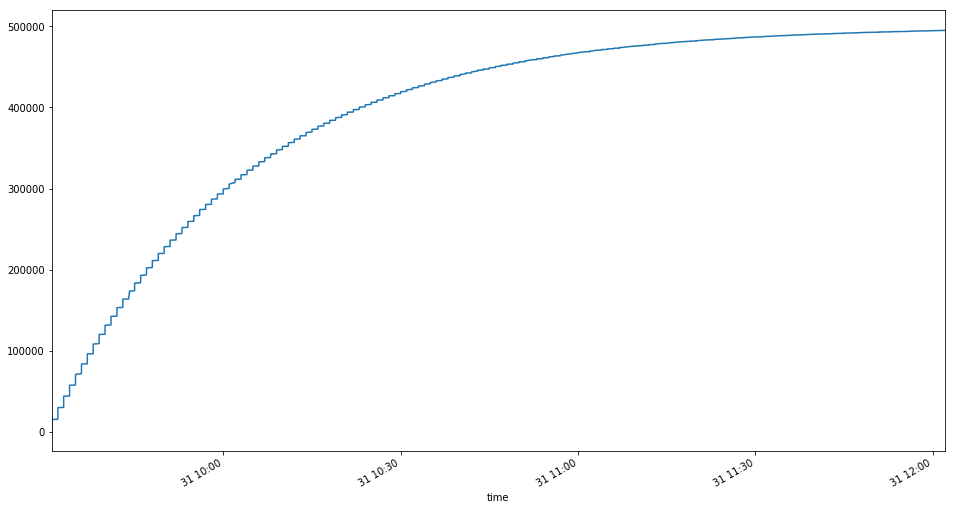

In [42]:
trades_df[ 'accum_shares' ].plot( figsize=( 16, 9 ) )
plt.show()

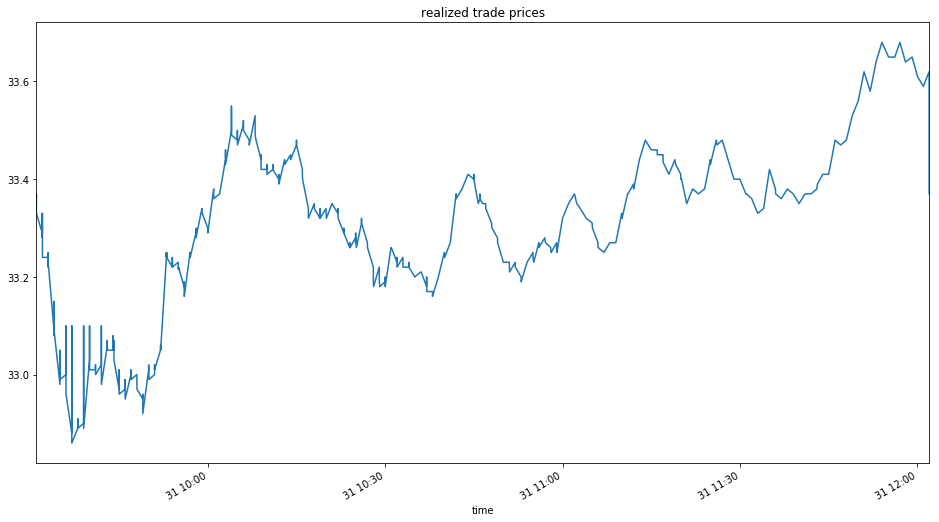

In [43]:
trades_df[ 'trade_price' ].plot( figsize = (16, 9) )
plt.title( 'realized trade prices' )
plt.show()

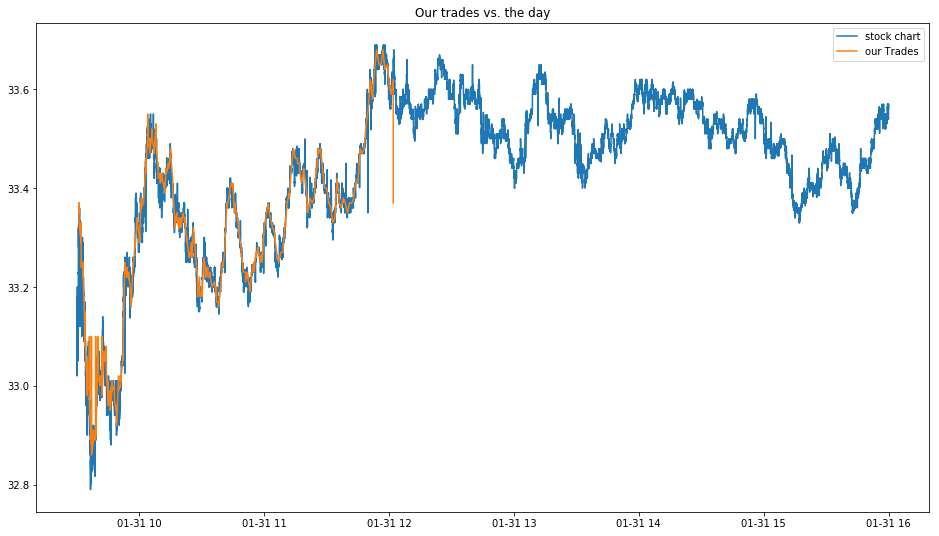

In [44]:
fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )

ax1.plot( market_trades[ 'trade_price' ], label = 'stock chart' )
ax1.plot( trades_df[ 'trade_price' ], label = 'our Trades' )
plt.title( 'Our trades vs. the day' )
plt.legend()
plt.show()

In [45]:
trades_df.to_csv( "trades.csv" )

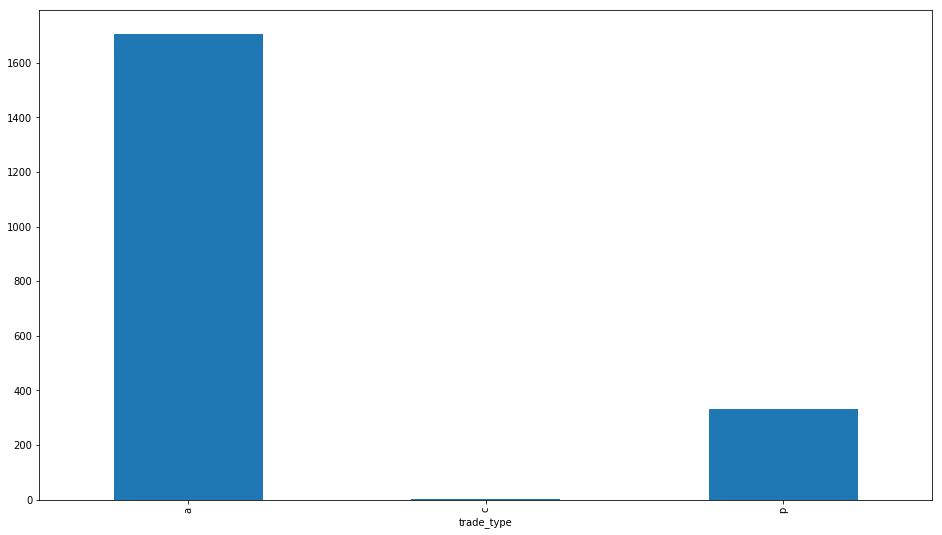

In [47]:
types = trades_df.groupby( [ 'trade_type' ] )[ 'trade_qty' ].count()
types.plot( kind = 'bar', figsize = (16, 9) )

In [37]:
len(trades_df)

2420